In [1]:
import cv2
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Input, Flatten, Lambda
import tensorflow as tf

In [3]:
from tensorflow.keras import callbacks

In [6]:
POS_PATH=os.path.join('data', 'positive')
NEG_PATH=os.path.join('data', 'negative')
ANC_PATH=os.path.join('data', 'anchor')

In [7]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

In [5]:
!tar -xf lfw.tgz

In [6]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    ex_path=os.path.join('lfw',directory,file)
    new_path=os.path.join('data','negative',file)
    os.replace(ex_path, new_path)

In [1]:
import uuid

In [2]:
uuid.uuid1()

UUID('7f3072eb-1fe9-11ef-8d6b-141333b74024')

In [8]:
cap=cv2.VideoCapture(0)
while cap.isOpened(): 
  ret, frame = cap.read()
  #cv2.imshow('Image', frame)
  frame=frame[200:450,200:450,:]

  if cv2.waitKey(1) & 0XFF == ord('a'):
    imgname=os.path.join('data','anchor','{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  if cv2.waitKey(1) & 0XFF == ord('p'):
    imgname=os.path.join('data','positive','{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
      
  cv2.imshow('Image', frame)

  if cv2.waitKey(1) & 0XFF == ord('e'):
      break
      
cap.release()
cv2.destroyAllWindows()

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\981d4579-1517-11ef-8410-141333b74024.jpg'


In [12]:
def preprocess(file_path):
    byte_img=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(byte_img)
    img=tf.image.resize(img,(105,105))
    img=img/255
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    return img

In [13]:
positives=tf.data.Dataset.zip((anchor,positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [14]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [15]:
samples = data.as_numpy_iterator()

In [16]:
examples = samples.next()

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [18]:
preprocess_twin(*examples)

(<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
 array([[[0.2862003 , 0.29004723, 0.22736733],
         [0.3344517 , 0.33829862, 0.27505988],
         [0.30696017, 0.31080708, 0.24030228],
         ...,
         [0.3983329 , 0.42388457, 0.40172657],
         [0.3999387 , 0.42726034, 0.39979255],
         [0.4114853 , 0.4388069 , 0.41133916]],
 
        [[0.30119583, 0.30504274, 0.24236284],
         [0.31477633, 0.31862324, 0.25594336],
         [0.3030455 , 0.30689242, 0.24421257],
         ...,
         [0.47468126, 0.5014439 , 0.4739761 ],
         [0.47602525, 0.50304747, 0.47142762],
         [0.4906837 , 0.51772577, 0.48578668]],
 
        [[0.29543135, 0.29927826, 0.2365984 ],
         [0.30800268, 0.3118496 , 0.24942257],
         [0.30454943, 0.30839634, 0.2492563 ],
         ...,
         [0.60565966, 0.6216166 , 0.5906089 ],
         [0.5954416 , 0.61338794, 0.5764119 ],
         [0.5902406 , 0.60833997, 0.57090473]],
 
        ...,
 
        [[0.26365492, 0.27495408

In [19]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [20]:
samples=data.as_numpy_iterator()

In [21]:
len(samples.next())

3

In [22]:
sam=samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


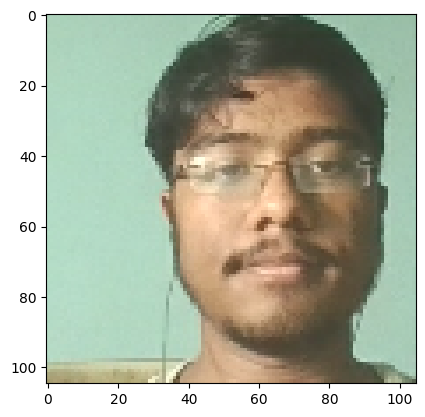

In [23]:
plt.imshow(sam[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


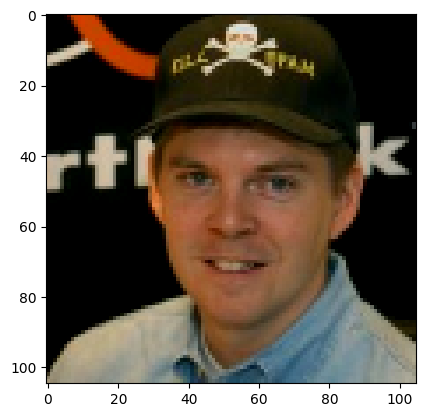

In [27]:
plt.imshow(sam[1])

In [24]:
sam[2]

0.0

In [25]:
train_data=data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [26]:
train_samples=train_data.as_numpy_iterator()

In [27]:
train_sample=train_samples.next()

In [28]:
len(train_sample[0])

16

In [29]:
test_data=data.skip(round(len(data)*.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [ ]:
inp=Input(shape=(100,100,3),name='input_image')

In [30]:
def make_embedding():
    inp=Input(shape=(105,105,3),name='input_image')
    
    c1=Conv2D(64,(10,10),activation='relu',kernel_regularizer=l2(0.01))(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    c2=Conv2D(128,(7,7),activation='relu',kernel_regularizer=l2(0.01))(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    c3=Conv2D(128,(4,4),activation='relu',kernel_regularizer=l2(0.01))(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    c4=Conv2D(256,(4,4),activation='relu',kernel_regularizer=l2(0.01))(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)

    return Model(inputs=inp,outputs=d1,name='embedding')

In [31]:
from keras.regularizers import l2

In [32]:
embedding=make_embedding()

In [33]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 105, 105, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [35]:
def make_siamese_model():
    input_image=Input(name='input_img',shape=(105,105,3))
    validation_image=Input(name='validation_img',shape=(105,105,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distances=siamese_layer(embedding(input_image),embedding(validation_image))
    classifier=Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [36]:
siamese_model=make_siamese_model()

In [37]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
binary_cross_loss=tf.losses.BinaryCrossentropy()

In [45]:
opt=tf.keras.optimizers.Adam(1e-5)

In [46]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = callbacks.LearningRateScheduler(scheduler)


In [48]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X=batch[:2]
        y=batch[2]
        y_hat=siamese_model(X,training=True)
        loss=binary_cross_loss(y,y_hat)
    grad=tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [49]:
def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        new_lr = scheduler(epoch, opt.learning_rate.numpy())
        opt.learning_rate.assign(new_lr)
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar=tf.keras.utils.Progbar(len(train_data))
        epoch_loss = 0
        for idx, batch in enumerate(train_data):
            loss=train_step(batch)
            epoch_loss += loss
            progbar.update(idx+1)
        avg_loss = epoch_loss / len(train_data)
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {avg_loss.numpy()}')

In [50]:
EPOCHS=25

In [51]:
train(train_data,EPOCHS)


 Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step
Epoch 1/25, Loss: 0.6599850654602051

 Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step
Epoch 2/25, Loss: 0.599937379360199

 Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step
Epoch 3/25, Loss: 0.5808058381080627

 Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step
Epoch 4/25, Loss: 0.4950290322303772

 Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step
Epoch 5/25, Loss: 0.4075750410556793

 Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step
Epoch 6/25, Loss: 0.32444071769714355

 Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step
Epoch 7/25, Loss: 0.26160699129104614

 Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step
Epoch 8/25, Loss: 0.23162205517292023

 Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step
Epoch 9/25, Loss: 0.19700269401073456

 Epoch 10/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step
Epoch 10/25, Loss: 0.16604973375797272

 Epoch 11/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step
Epoch 11/25, Loss: 0.14528094232082367

 

In [52]:
from tensorflow.keras.metrics import Precision,Recall

In [53]:
test_input, test_val, y_true=test_data.as_numpy_iterator().next()

In [54]:
test_input

array([[[[0.32406187, 0.33691832, 0.30162516],
         [0.34617   , 0.3590265 , 0.3243078 ],
         [0.342274  , 0.35149217, 0.32606083],
         ...,
         [0.4864443 , 0.5117477 , 0.48631632],
         [0.49045193, 0.5193937 , 0.49214312],
         [0.50942093, 0.5383627 , 0.51111215]],

        [[0.32376552, 0.33604747, 0.3010416 ],
         [0.3252564 , 0.3381129 , 0.31086236],
         [0.31377384, 0.32260898, 0.3034011 ],
         ...,
         [0.607501  , 0.632777  , 0.60261995],
         [0.6097236 , 0.63837814, 0.6065318 ],
         [0.62181497, 0.651044  , 0.61891043]],

        [[0.4082816 , 0.4130954 , 0.3818236 ],
         [0.3789971 , 0.39156634, 0.36489028],
         [0.34831986, 0.35715503, 0.34158543],
         ...,
         [0.6120808 , 0.6370013 , 0.59604084],
         [0.6245984 , 0.64951885, 0.61020434],
         [0.62459385, 0.6539186 , 0.612402  ]],

        ...,

        [[0.60800266, 0.62124217, 0.5658424 ],
         [0.61629605, 0.62953544, 0.5741357 ]

In [55]:
test_var=test_data.as_numpy_iterator().next()

In [56]:
y_hat=siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[9.90707338e-01],
       [1.38219139e-05],
       [8.55724275e-01],
       [8.01412523e-01],
       [1.16725634e-04],
       [5.33151999e-03],
       [1.04267092e-04],
       [9.93806899e-01],
       [9.68422413e-01],
       [6.29330607e-05],
       [2.43639033e-02],
       [9.12202477e-01],
       [4.98848858e-05],
       [5.11308193e-01],
       [9.62904215e-01],
       [2.44440883e-03]], dtype=float32)

In [57]:
l=[]
for pred in y_hat:
    if pred>0.5:
        l.append(1)
    else:
        l.append(0)
print(l)

[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0]


In [58]:
y_true

array([1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.],
      dtype=float32)

In [59]:
m=Recall()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [60]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

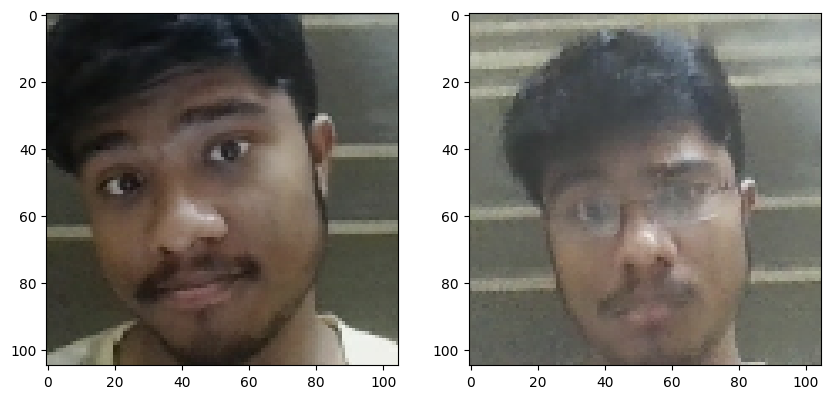

In [61]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [62]:
siamese_model.save('siamesemodel5.keras')

In [63]:
model=tf.keras.models.load_model('siamesemodel5.keras',custom_objects={'L1Dist':L1Dist})

In [64]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 105, 105, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
test_anchor = preprocess(os.path.join('data','anchor','1facf4ad-1518-11ef-8802-141333b74024.jpg'))
test_positive = preprocess(os.path.join('data','positive','a7e3daf5-1518-11ef-b6c9-141333b74024.jpg'))
test_negative = preprocess(os.path.join('data','negative','Abba_Eban_0001.jpg'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


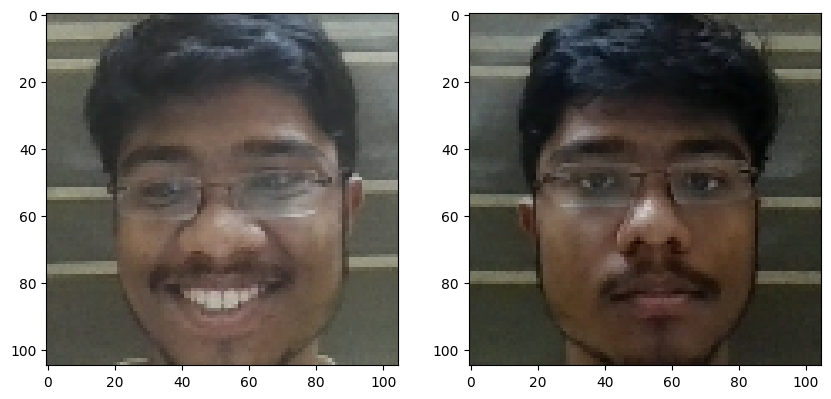

In [66]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_anchor)
plt.subplot(1,2,2)
plt.imshow(test_positive)
plt.show()

In [67]:
test_anchor=tf.expand_dims(test_anchor,axis=0)
test_positive=tf.expand_dims(test_positive,axis=0)
test_negative=tf.expand_dims(test_negative,axis=0)

In [68]:
positive_pred = model([test_anchor, test_positive])
negative_pred = model([test_anchor, test_negative])

In [69]:
# test_anchor = tf.expand_dims(test_anchor, axis=0)
# test_positive = tf.expand_dims(test_positive, axis=0)
# test_negative = tf.expand_dims(test_negative, axis=0)

# Make predictions


print(f'Positive pair prediction: {positive_pred.numpy()}')
print(f'Negative pair prediction: {negative_pred.numpy()}')

Positive pair prediction: [[0.5921826]]
Negative pair prediction: [[0.00010343]]


In [70]:
def verify(model,detection_threshold, verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('Application_data','Verification_images')):
        input_img=preprocess(os.path.join('Application_data','Input_image','Input_image.jpg'))
        validation_img=preprocess(os.path.join('Application_data','Verification_images',image))
        # result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        input_img = tf.expand_dims(input_img, axis=0)  # Shape: (1, 105, 105, 3)
        validation_img = tf.expand_dims(validation_img, axis=0)  # Shape: (1, 105, 105, 3)
        result = model.predict([input_img, validation_img],verbose=0)
        results.append(result)
    detection=np.sum(np.array(results)>detection_threshold)
    verification=detection/len(os.listdir(os.path.join('Application_data','Verification_images')))
    verified=verification>verification_threshold
    return results, verified

In [71]:
input_img=preprocess(os.path.join('Application_data','Input_image','Input_image.jpg'))
validation_img=preprocess(os.path.join('Application_data','Verification_images','00c8261d-1519-11ef-b940-141333b74024 - Copy - Copy.jpg'))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


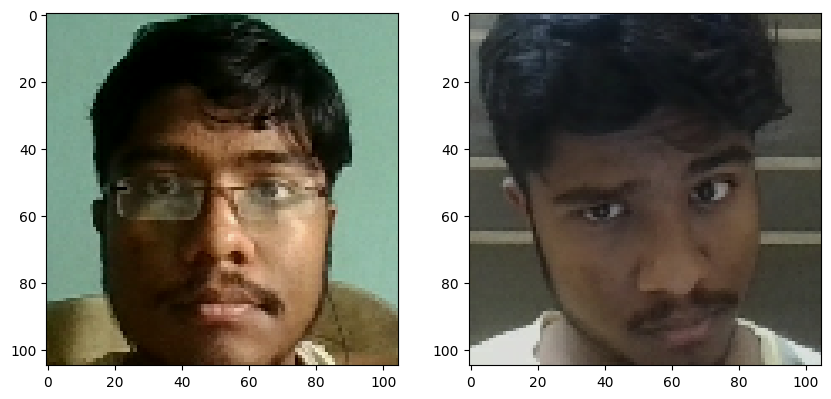

In [72]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(input_img)
plt.subplot(1,2,2)
plt.imshow(validation_img)
plt.show()

In [73]:
input_img = tf.expand_dims(input_img, axis=0)  # Shape: (1, 105, 105, 3)
validation_img = tf.expand_dims(validation_img, axis=0)  # Shape: (1, 105, 105, 3)
result = model([input_img, validation_img])

In [75]:
print(result)

tf.Tensor([[0.9997229]], shape=(1, 1), dtype=float32)


In [95]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame=frame[200:450,200:450,:]
    cv2.imshow('verification',frame)
    if cv2.waitKey(10) & 0xFF==ord('v'):
        cv2.imwrite(os.path.join('Application_data','Input_image','Input_image.jpg'),frame)
        results,verified=verify(model,0.9,0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break;
cap.release()
cv2.destroyAllWindows()

False


In [96]:
np.sum(np.squeeze(results)>0.9)

16

In [91]:
results

[array([[0.99989796]], dtype=float32),
 array([[0.99973786]], dtype=float32),
 array([[0.99964666]], dtype=float32),
 array([[0.70753914]], dtype=float32),
 array([[0.9866416]], dtype=float32),
 array([[0.98468477]], dtype=float32),
 array([[0.9167175]], dtype=float32),
 array([[0.7266096]], dtype=float32),
 array([[0.39951363]], dtype=float32),
 array([[0.9509899]], dtype=float32),
 array([[0.99164486]], dtype=float32),
 array([[0.98165774]], dtype=float32),
 array([[0.999484]], dtype=float32),
 array([[0.99796855]], dtype=float32),
 array([[0.9961878]], dtype=float32),
 array([[0.99479854]], dtype=float32),
 array([[0.99975157]], dtype=float32),
 array([[0.9998138]], dtype=float32),
 array([[0.92394847]], dtype=float32),
 array([[0.97469705]], dtype=float32),
 array([[0.9546786]], dtype=float32),
 array([[0.98504764]], dtype=float32),
 array([[0.89525574]], dtype=float32),
 array([[0.8967532]], dtype=float32),
 array([[0.9231486]], dtype=float32),
 array([[0.9583217]], dtype=float32)